In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

## 2.1 - 2.2


In [33]:
def myFun(X, f_number = 1):
    
    if f_number == 2:
        return (10* np.sin(X) + X**2)
    
    elif f_number == 3:
        return (np.sign(X)*(300 + X**2) + 20* np.sin(X))
    
    else:
        
        return (X * np.sin(X) + 2*X)
    

myF = np.vectorize(myFun, excluded=["f_number"])

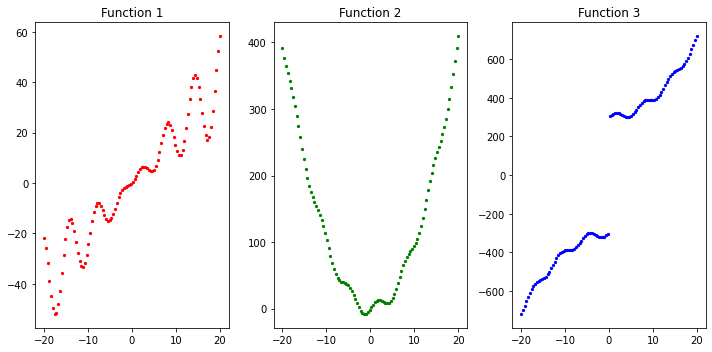

In [53]:
dataset = []

fig, ax = plt.subplots(1, 3, figsize=[10,5])
for f_number, color in enumerate(["r", "g", "b"]):

    tr = 20
    n_samples = 100
    X = np.linspace(-tr, tr, n_samples)

    y = myF(X, f_number+1)
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42, shuffle=True
    )
    y_test = y_test[X_test.argsort()]
    X_test.sort()
    
    #append to dataset
    dataset.append([X_train, y_train, X_test, y_test])
    
    ax[f_number].scatter(X , y , c = color, s= 5)
    ax[f_number].set_title(f"Function {f_number+1}")

plt.tight_layout()

I'll use polynomial regression, there is no linarity. Only the 3rd function seems to have somthing linear.

## 2.3 - 2.4 - 2.5
### Linear regression

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [43]:
reg = LinearRegression(fit_intercept= True )

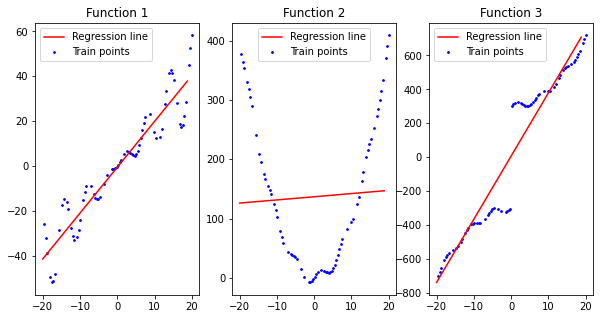

,R2,MAE,MSE
Function 1,0.891992,5.965427,57.420303
Function 2,-0.018700,96.649543,12926.806156
Function 3,0.932233,83.009903,13568.763950


In [69]:
results = {"R2": [], "MAE": [], "MSE":[]}
predicted = []
fig, ax = plt.subplots(1, 3, figsize=[10,5])

for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
        
    X_test = function[2]
    y_test = function[3]
    
    reg.fit(X_train[:, np.newaxis] , y_train)
    y_pred = reg.predict(X_test[:, np.newaxis])
    predicted.append(y_pred)
    
    ax[i].scatter(X_train , y_train , c = "b", s= 3, label= "Train points")
    ax[i].plot(X_test, y_pred, c= "r", label="Regression line")
    ax[i].set_title(f"Function {i+1}")
    ax[i].legend()
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results["R2"].append(r2)
    results["MAE"].append(mae)
    results["MSE"].append(mse)
    
plt.show()   
df = pd.DataFrame(results, index = ["Function 1","Function 2","Function 3" ])
df

### Linear regression - Evaluation with cross validation


In [58]:
from sklearn.model_selection import cross_val_score


In [90]:
results_cv = {"R2_CV": [], "MAE_CV": [], "MSE_CV":[]}
reg = LinearRegression(fit_intercept= True)
for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
        
    X_test = function[2]
    y_test = function[3]
    
    
    
    r2 = cross_val_score(reg, X_train[:, np.newaxis], y_train, cv = 5 , scoring="r2")
    mse = -cross_val_score(reg, X_train[:, np.newaxis], y_train, cv = 5 , scoring = "neg_mean_squared_error")
    mae = -cross_val_score(reg, X_train[:, np.newaxis], y_train, cv = 5 , scoring = "neg_mean_absolute_error")
    
    results_cv["R2_CV"].append(r2.mean())
    results_cv["MAE_CV"].append(mae.mean())
    results_cv["MSE_CV"].append(mse.mean())

df_cv = pd.DataFrame(results_cv, index = ["Function 1","Function 2","Function 3" ])
df_cv

,R2_CV,MAE_CV,MSE_CV
Function 1,0.861746,6.757043,73.686832
Function 2,-0.182050,113.770923,17363.486799
Function 3,0.900238,93.610352,16427.370724


## Compare the result
 - Use kfold = 5

In [79]:
comparison = pd.concat((df, df_cv), axis = 1 )

In [80]:
comparison

,R2,MAE,MSE,R2_CV,MAE_CV,MSE_CV
Function 1,0.891992,5.965427,57.420303,0.861746,6.757043,73.686832
Function 2,-0.018700,96.649543,12926.806156,-0.182050,113.770923,17363.486799
Function 3,0.932233,83.009903,13568.763950,0.900238,93.610352,16427.370724


We can easily see that Kfold has worst results, but it's less overfitted. R" score for f1 and f3 is quite well, but for f2 is really bad. As we can see in the graphs f2 is a parabola so, can't be fitted with a line.  Functon3 seems good if we look R2, but the MSE is really bad, this is why there is a big step in 0, maybe is a non-continious function.


## Polynomial regression

#### GridSearchCV for get best hyperparam for Linear, Lasso, Ridge

In [146]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

overall_best_model_r2 = [[],[],[]]

### Linear with Polynomial

In [127]:
n_degree = list(range(0,6))
reg_lin = make_pipeline(PolynomialFeatures(), LinearRegression())
param_grid = {'polynomialfeatures__degree': n_degree,
             'linearregression__fit_intercet': [True, False]}

In [144]:
from sklearn.model_selection import GridSearchCV

best_model = [[],[],[]]
#create gridsearch based on R2
gridsearch = GridSearchCV(reg_lin, param_grid, scoring = "r2", cv = 5)
for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
    
    res = gridsearch.fit(X_train[:, np.newaxis], y_train)
    best_model[0].append(res.best_estimator_)
    print(f"Best param for function {i+1}: {res.best_params_}")
    print(f"with R2: {res.best_score_:.2f}")

Best param for function 1: {'polynomialfeatures__degree': 1}
with R2: 0.86
Best param for function 2: {'polynomialfeatures__degree': 2}
with R2: 1.00
Best param for function 3: {'polynomialfeatures__degree': 5}
with R2: 0.94


In [148]:
overall_best_model_r2[0].append(best_model[0])

In [149]:
#create gridsearch based on MSE
gridsearch = GridSearchCV(reg_lin, param_grid, scoring = "neg_mean_squared_error", cv = 5)
for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
    
    res = gridsearch.fit(X_train[:, np.newaxis], y_train)
    best_model[1].append(res.best_estimator_)
    print(f"Best param for function {i+1}: {res.best_params_}")
    print(f"with MSE: {-res.best_score_:.2f}")

Best param for function 1: {'polynomialfeatures__degree': 1}
with MSE: 73.69
Best param for function 2: {'polynomialfeatures__degree': 2}
with MSE: 51.25
Best param for function 3: {'polynomialfeatures__degree': 5}
with MSE: 10892.18


In [150]:
gridsearch = GridSearchCV(reg_lin, param_grid, scoring = "neg_mean_absolute_error", cv = 5)
for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
    
    res = gridsearch.fit(X_train[:, np.newaxis], y_train)
    best_model[2].append(res.best_estimator_)
    
    print(f"Best param for function {i+1}: {res.best_params_}")
    print(f"with MAE: {-res.best_score_:.2f}")

Best param for function 1: {'polynomialfeatures__degree': 1}
with MAE: 6.76
Best param for function 2: {'polynomialfeatures__degree': 2}
with MAE: 6.53
Best param for function 3: {'polynomialfeatures__degree': 5}
with MAE: 66.96


If we increase the n_degree we obtain better approximation, but increase overfitting so we use 1st, 2nd and 5th degree
We can see that in all measure 1,2,5 is the best solution.
Now we plot the model:

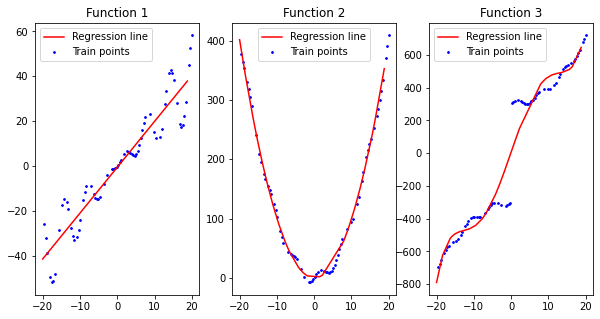

,R2_LP,MAE_LP,MSE_LP
Function 1,0.891992,5.965427,57.420303
Function 2,0.995889,6.218844,52.162968
Function 3,0.962500,63.647948,7508.528299


In [151]:
fig, ax = plt.subplots(1, 3, figsize=[10,5])
result_l_poly = {"R2_LP":[],"MAE_LP":[], "MSE_LP":[] }
for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
    
    X_test = function[2]
    y_test = function[3]
    
    reg.fit(X_train[:, np.newaxis] , y_train)
    y_pred = best_model[0][i].predict(X_test[:, np.newaxis])
    
    ax[i].scatter(X_train , y_train , c = "b", s= 3, label= "Train points")
    ax[i].plot(X_test, y_pred, c= "r", label="Regression line")
    ax[i].set_title(f"Function {i+1}")
    ax[i].legend()
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    result_l_poly["R2_LP"].append(r2.mean())
    result_l_poly["MAE_LP"].append(mae.mean())
    result_l_poly["MSE_LP"].append(mse.mean())
    
plt.show()
df_lp = pd.DataFrame(result_l_poly, index = ["Function 1","Function 2", "Function 3" ])
df_lp

Compare to result_cv with linear:


In [140]:
comparison_linear_linpoly = pd.concat((df_cv, df_lp), axis =1 )

In [141]:
comparison_linear_linpoly

,R2_CV,MAE_CV,MSE_CV,R2_LP,MAE_LP,MSE_LP
Function 1,0.861746,6.757043,73.686832,0.891992,5.965427,57.420303
Function 2,-0.182050,113.770923,17363.486799,0.995889,6.218844,52.162968
Function 3,0.900238,93.610352,16427.370724,0.962500,63.647948,7508.528299


### Lasso only on r2

In [152]:
from sklearn.linear_model import Lasso

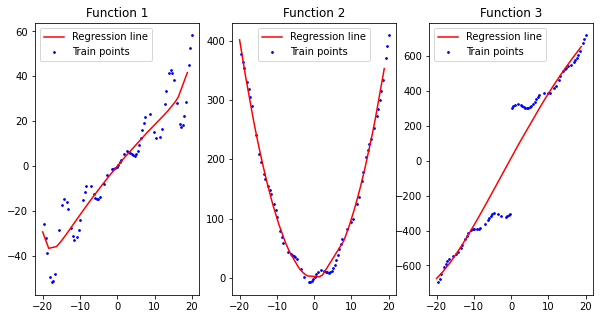

R2 for Lasso: 0.874128140486422 with param:Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=18)),
                ('lasso', Lasso(alpha=0.01, tol=0.4))])
R2 for Lasso: 0.9963025292753486 with param:Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=1, tol=0.4))])
R2 for Lasso: 0.9049595381112265 with param:Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=8)),
                ('lasso', Lasso(alpha=0.01, tol=0.4))])


In [169]:
reg_lasso = make_pipeline(PolynomialFeatures(), Lasso(tol = 0.4))

param_grid = {'polynomialfeatures__degree':list(range(2,20,2)), 
              'lasso__alpha':[1e-2, 0.1, 1]}
grid_search = GridSearchCV(reg_lasso, param_grid, scoring = "r2", cv = 5)
md_lasso = []
R2_lasso =[]

fig, ax = plt.subplots(1, 3, figsize=[10,5])
for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
    
    res = grid_search.fit(X_train[:, np.newaxis], y_train)
    md_lasso.append(res.best_estimator_)
    
    X_test = function[2]
    y_test = function[3]
    
    y_pred = res.best_estimator_.predict(X_test[:, np.newaxis])
    
    R2_lasso.append(res.best_score_)
     
    ax[i].scatter(X_train , y_train , c = "b", s= 3, label= "Train points")
    ax[i].plot(X_test, y_pred, c= "r", label="Regression line")
    ax[i].set_title(f"Function {i+1}")
    ax[i].legend()
    
    
plt.show()

for i in range(3):
    print(f"R2 for Lasso: {R2_lasso[i]} with param:{md_lasso[i]}")


In [175]:
comparison_linear_linpoly["R2_Lasso"] = R2_lasso
comparing_methods = comparison_linear_linpoly 

,R2_CV,MAE_CV,MSE_CV,R2_LP,MAE_LP,MSE_LP,R2_Lasso
Function 1,0.861746,6.757043,73.686832,0.891992,5.965427,57.420303,0.874128
Function 2,-0.182050,113.770923,17363.486799,0.995889,6.218844,52.162968,0.996303
Function 3,0.900238,93.610352,16427.370724,0.962500,63.647948,7508.528299,0.904960


Lasso it's better for F2, and obtain good result with F1 and F3. It's good, because it prevents overfitting

#### Ridge

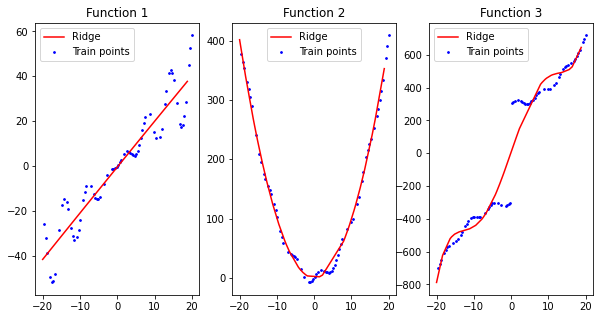

R2 for Lasso: 0.852671140690535 with param:Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=0.4, tol=0.9))])
R2 for Lasso: 0.9962933190637075 with param:Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=0.5, tol=0.9))])
R2 for Lasso: 0.9352149822823661 with param:Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('ridge', Ridge(alpha=0.4, tol=0.9))])


In [192]:
from sklearn.linear_model import Ridge
reg_ridge = make_pipeline(PolynomialFeatures(), Ridge(tol = 0.9))

param_grid = {'polynomialfeatures__degree':list(range(2,6,1)), 
              'ridge__alpha':[0.5, 0.4]}
grid_search = GridSearchCV(reg_ridge, param_grid, scoring = "r2", cv = 5)
md_ridge = []
R2_ridge =[]

fig, ax = plt.subplots(1, 3, figsize=[10,5])
for i, function in enumerate(dataset):
    X_train =function[0]
    y_train =function[1]
    
    res = grid_search.fit(X_train[:, np.newaxis], y_train)
    md_ridge.append(res.best_estimator_)
    
    X_test = function[2]
    y_test = function[3]
    
    y_pred = res.best_estimator_.predict(X_test[:, np.newaxis])
    
    R2_ridge.append(res.best_score_)
     
    ax[i].scatter(X_train , y_train , c = "b", s= 3, label= "Train points")
    ax[i].plot(X_test, y_pred, c= "r", label="Ridge")
    ax[i].set_title(f"Function {i+1}")
    ax[i].legend()
    
    
plt.show()

for i in range(3):
    print(f"R2 for Lasso: {R2_ridge[i]} with param:{md_ridge[i]}")

In [191]:
comparison["RIDGE"] = R2_ridge
comparison

,R2,MAE,MSE,R2_CV,MAE_CV,MSE_CV,R2_Lasso,RIDGE
Function 1,0.891992,5.965427,57.420303,0.861746,6.757043,73.686832,0.874128,0.977840
Function 2,-0.018700,96.649543,12926.806156,-0.182050,113.770923,17363.486799,0.996303,0.997006
Function 3,0.932233,83.009903,13568.763950,0.900238,93.610352,16427.370724,0.904960,0.952450


If we put high degree on ridge it will obtain a good r2=1 but overfitted


# 2.6

In [194]:
def inject_noise(y):
#Add a random noise drawn from a normal distribution."""
    return y + np.random.normal(0, 50, size=y.size)